In this notebook, we consider **crime** data from the *Berliner Polizei* and perform some **geographic visualisations** (with [GeoPandas](https://geopandas.org/index.html)) to understand, for example, where are the hotspots of **drug-related crimes** in Berlin

In [ ]:
!pip install git+git://github.com/geopandas/geopandas.git

In [ ]:
!pip install geopy

In [56]:
import pandas as pd
import geopandas as gpd
from geopy import Nominatim
import matplotlib.pyplot as plt

from google.colab import drive
from google.colab import files

In [ ]:
drive.mount('/content/gdrive', force_remount=True)
gdrive_path = "/content/gdrive/My Drive/Colab Notebooks/Berlin/"

In [ ]:
!ls /"content"/"gdrive"/"My Drive"/"Colab Notebooks"/"Berlin"

We now load shapes (in the form of .geojson files) for both **neighbourhoods** and **districts** (neighbourhood ⊂ district)

In [5]:
neighbourhoods = gpd.read_file(gdrive_path+"neighbourhoods.geojson")

In [6]:
districts = gpd.read_file("https://raw.githubusercontent.com/m-hoerz/berlin-shapes/master/berliner-bezirke.geojson")

In [7]:
districts

,gml_id,spatial_name,spatial_alias,spatial_type,geometry
0,re_bezirke.01,01,Mitte,Polygon,"POLYGON ((13.37325 52.50377, 13.37342 52.50399..."
1,re_bezirke.02,02,Friedrichshain-Kreuzberg,Polygon,"POLYGON ((13.44471 52.49422, 13.44498 52.49443..."
2,re_bezirke.03,03,Pankow,Polygon,"POLYGON ((13.44226 52.53097, 13.44561 52.52788..."
3,re_bezirke.04,04,Charlottenburg-Wilmersdorf,Polygon,"POLYGON ((13.30748 52.46788, 13.30833 52.46754..."
4,re_bezirke.05,05,Spandau,Polygon,"POLYGON ((13.21570 52.50936, 13.21570 52.50935..."
5,re_bezirke.06,06,Steglitz-Zehlendorf,Polygon,"POLYGON ((13.26906 52.40424, 13.27045 52.40416..."
6,re_bezirke.07,07,Tempelhof-Schöneberg,Polygon,"POLYGON ((13.41802 52.37623, 13.41951 52.37618..."
7,re_bezirke.08,08,Neukölln,Polygon,"POLYGON ((13.46090 52.42075, 13.46355 52.42108..."
8,re_bezirke.09,09,Treptow-Köpenick,Polygon,"POLYGON ((13.65750 52.35191, 13.65789 52.35204..."
9,re_bezirke.10,10,Marzahn-Hellersdorf,Polygon,"POLYGON ((13.58657 52.48101, 13.58878 52.48001..."


In [8]:
neighbourhoods = neighbourhoods \
  [~ neighbourhoods['neighbourhood_group'].isnull()]

In [9]:
neighbourhoods

,neighbourhood,neighbourhood_group,geometry
0,Blankenfelde/Niederschönhausen,Pankow,"MULTIPOLYGON (((13.41191 52.61487, 13.41183 52..."
1,Helmholtzplatz,Pankow,"MULTIPOLYGON (((13.41405 52.54929, 13.41422 52..."
2,Wiesbadener Straße,Charlottenburg-Wilm.,"MULTIPOLYGON (((13.30748 52.46788, 13.30743 52..."
3,Schmöckwitz/Karolinenhof/Rauchfangswerder,Treptow - Köpenick,"MULTIPOLYGON (((13.70973 52.39630, 13.70926 52..."
4,Müggelheim,Treptow - Köpenick,"MULTIPOLYGON (((13.73762 52.40850, 13.73773 52..."
...,...,...,...
135,Hellersdorf-Ost,Marzahn - Hellersdorf,"MULTIPOLYGON (((13.62135 52.52704, 13.62079 52..."
136,Mahlsdorf,Marzahn - Hellersdorf,"MULTIPOLYGON (((13.65554 52.52982, 13.65693 52..."
137,Ost 1,Reinickendorf,"MULTIPOLYGON (((13.36666 52.55823, 13.36561 52..."
138,Ost 2,Reinickendorf,"MULTIPOLYGON (((13.36418 52.56298, 13.36423 52..."


In addition, there are also shapefiles for a variety of other interesting things; these are free data from [Geofrabik](http://download.geofabrik.de/europe/germany/berlin.html)

In [10]:
railways = gpd.read_file(gdrive_path+"shp/gis_osm_railways_free_1.shp")
subway = railways.query("fclass == 'subway'")

In [11]:
transport = gpd.read_file(gdrive_path+"shp/gis_osm_transport_free_1.shp")
railway_station = transport.query("fclass == 'railway_station'")

In [12]:
landuse = gpd.read_file(gdrive_path+"shp/gis_osm_landuse_a_free_1.shp")
park = landuse.query("fclass == 'park'")

In [13]:
water = gpd.read_file(gdrive_path+"shp/gis_osm_waterways_free_1.shp")
river = water.query("fclass == 'river'")
stream = water.query("fclass == 'stream'")

Here we plot some of the files for *test*

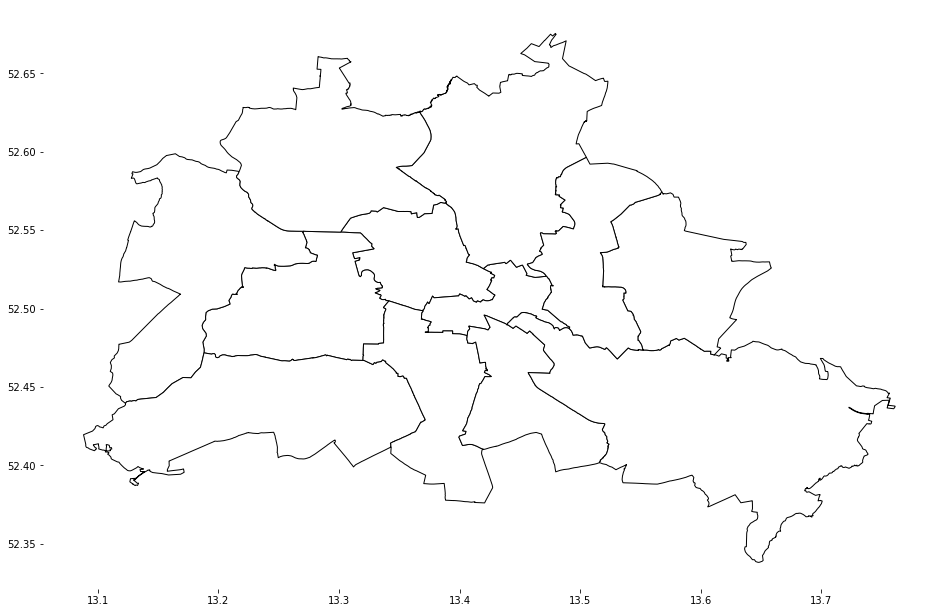

In [81]:
fig, ax = plt.subplots(figsize=(16,11))

districts.plot(ax=ax, color='white', linewidth=1, edgecolor='k')
#neighbourhoods.plot(ax=ax, column='neighbourhood_group',
#                    categorical=True, legend=True, 
#                    legend_kwds={'title': 'Neighbourhood', 'loc': 'upper right'},
#                    cmap='tab20', edgecolor='black', lw=0.5)

#subway.plot(ax=ax, color='tab:purple', lw=1)
#railway_station.plot(ax=ax, color='yellow', marker='.', markersize=50)
#park.plot(ax=ax, color='tab:green', edgecolor='k', lw=0.1)
#river.plot(ax=ax, color='tab:blue', lw=1)
#stream.plot(ax=ax, color='tab:blue', lw=0.6)

ax.set(aspect=1.3, frame_on=False);

We load the dataset (available from [Kaggle](https://www.kaggle.com/danilzyryanov/crime-in-berlin-2012-2019)); then we downselect to year 2019 and perform a ```groupby``` in order to aggregate at district level

In [36]:
crimes = pd.read_csv(gdrive_path+"Berlin_crimes.csv")

drugs_19 = crimes[['Year', 'District', 'Drugs']].query("Year == 2019").drop(labels='Year', axis=1)
drugs_19_by_dist = drugs_19.groupby(['District']).sum()

In [37]:
# I use the names from the .geojson file to avoid problems with the join
names = sorted(list(set(neighbourhoods.neighbourhood_group)))

In [38]:
# I create a new dataframe to collect the result from the group-by
df = pd.DataFrame(data={'District': names, 'Drugs_sum': list(drugs_19_by_dist.Drugs)}, index=range(0,12))
df = df.sort_values(by='Drugs_sum', ascending=False)

In [39]:
df

,District,Drugs_sum
1,Friedrichshain-Kreuzberg,5232
4,Mitte,4233
5,Neukölln,2126
10,Tempelhof - Schöneberg,1209
0,Charlottenburg-Wilm.,1174
7,Reinickendorf,843
6,Pankow,788
11,Treptow - Köpenick,633
8,Spandau,606
3,Marzahn - Hellersdorf,544


In [40]:
# This will come in handy for the following plots
first_name, first_val = df.iloc[0,0], df.iloc[0,1]
second_name, second_val = df.iloc[1,0], df.iloc[1,1]
third_name, third_val = df.iloc[2,0], df.iloc[2,1]

We now fix all the tiny **mismatches** between the district names in the .csv and .geojson files; we can thus **merge** the geo-dataframe ```districts``` with the pandas dataframe ```df```; then, we're all set for **plotting**

In [44]:
to_replace = {'Charlottenburg-Wilmersdorf':'Charlottenburg-Wilm.', 'Steglitz-Zehlendorf':'Steglitz - Zehlendorf',
              'Tempelhof-Schöneberg':'Tempelhof - Schöneberg', 'Treptow-Köpenick':'Treptow - Köpenick',
              'Marzahn-Hellersdorf':'Marzahn - Hellersdorf', }

districts.replace(to_replace=to_replace, inplace=True)

In [45]:
gdf = districts.merge(df, left_on='spatial_alias', right_on='District')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

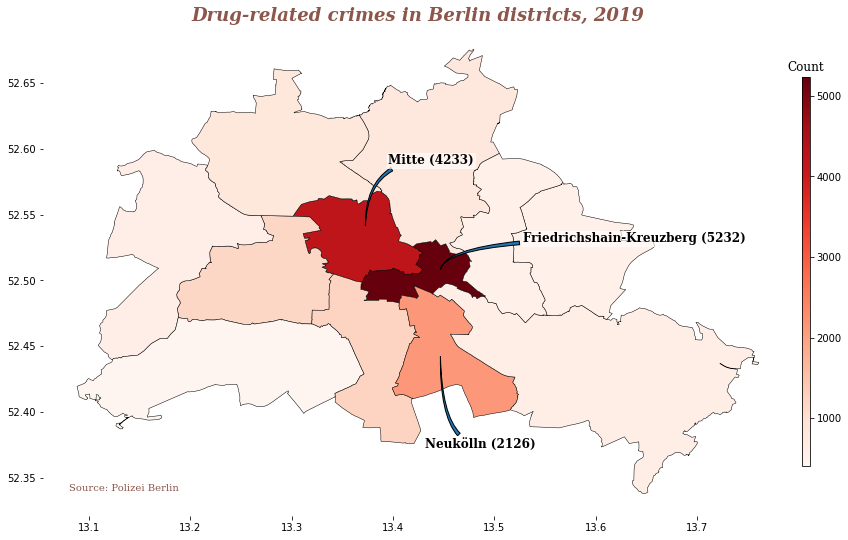

In [47]:
fig, ax = plt.subplots(figsize=(16,11))

gdf.plot(ax=ax, column='Drugs_sum', cmap='Reds',
         edgecolor='black', lw=0.5)

#park.plot(ax=ax, color='tab:green', edgecolor='k', lw=0.1)
#river.plot(ax=ax, color='tab:blue', lw=1)

vmin = gdf['Drugs_sum'].min()
vmax = gdf['Drugs_sum'].max()
sm = plt.cm.ScalarMappable(cmap='Reds', norm=plt.Normalize(vmin=vmin, vmax=vmax))
cbar = fig.colorbar(sm, pad=0.01, shrink=0.65, aspect=50)
cbar.ax.set_title('Count', family='serif')

plt.annotate(f'{first_name} ({first_val})', xy=(0.53, 0.5), xytext=(0.64, 0.56), xycoords='axes fraction',
             arrowprops=dict(arrowstyle="wedge", connectionstyle="angle3,angleA=0,angleB=-90"),
             bbox=dict(color='white', alpha=0.6, pad=1),
             family='serif', size='large', style='normal', weight='bold')

plt.annotate(f'{second_name} ({second_val})', xy=(0.43, 0.59), xytext=(0.46, 0.72), xycoords='axes fraction',
             arrowprops=dict(arrowstyle="wedge", connectionstyle="angle3,angleA=0,angleB=-90"),
             bbox=dict(color='white', alpha=0.6, pad=1),
             family='serif', size='large', style='normal', weight='bold')

plt.annotate(f'{third_name} ({third_val})', xy=(0.53, 0.33), xytext=(0.51, 0.14), xycoords='axes fraction',
             arrowprops=dict(arrowstyle="wedge", connectionstyle="angle3,angleA=0,angleB=-90"),
             bbox=dict(color='white', alpha=0.6, pad=1),
             family='serif', size='large', style='normal', weight='bold')

ax.set(aspect=1.3, frame_on=False)

ax.text(13.08, 52.34, 'Source: Polizei Berlin',   #Vincenzo Ventriglia\n
        color='tab:brown', family='serif', style='normal', size=10)

plt.title('Drug-related crimes in Berlin districts, 2019', color='tab:brown', family='serif', size=18, style='italic', weight='bold')

plt.savefig(gdrive_path+"drug2019.png", dpi=200, bbox_inches='tight')
files.download(gdrive_path+"drug2019.png");

Now let's try to break this data down to a less aggregate level, passing from districts to **neighbourhoods**

First, we need to manage **mismatches** between the dataset and the neighbourhoods shape file

In [48]:
# We look for unique values using the set
#set(crimes.Location)

In [49]:
#set(neighbourhoods.neighbourhood)

In [50]:
to_replace = {'Alt  Treptow':'Alt-Treptow', 'Kölln. Vorstadt/Spindlersf.':'Köllnische Vorstadt/Spindlersfeld',
              'MV 1':'MV 1 - Märkisches Viertel', 'MV 2':'MV 2 - Rollbergsiedlung',
              'Nord 1':'Nord 1 - Frohnau/Hermsdorf', 'Nord 2':'Nord 2 - Waidmannslust/Wittenau/Lübars',
              'Ost 1':'Ost 1 - Reginhardstr.', 'Ost 2':'Ost 2 - Alt-Reinickendorf',
              'West 1':'West 1 - Tegel-Süd/Flughafensee', 'West 2':'West 2 - Heiligensee/Konradshöhe',
              'West 3':'West 3 - Borsigwalde/Freie Scholle','West 4':'West 4 - Auguste-Viktoria-Allee',
              'West 5':'West 5 - Tegel/Tegeler Forst', 'Brunnenstr. Nord':'Brunnenstraße Nord',
              'Brunnenstr. Süd':'Brunnenstraße Süd', 'Charlottenburg Nord':'Charlottenburg-Nord',
              'Zehlendorf  Nord':'Zehlendorf Nord', 'Zehlendorf  Südwest':'Zehlendorf Südwest',
              'Gatow / Kladow':'Gatow/Kladow', 'nördliche Luisenstadt':'Nördliche Luisenstadt',
              'südliche Luisenstadt':'Südliche Luisenstadt'}

neighbourhoods.replace(to_replace=to_replace, inplace=True)

We downselect our data to year 2019 and sort it, so it's ready to use

In [51]:
drugs_19_by_neig = crimes[['Year', 'District', 'Location', 'Drugs']].query("Year == 2019").drop(labels='Year', axis=1).sort_values(by='Drugs', ascending=False)

In [52]:
# Again, this will come in handy for plotting
first_neig_name, first_neig_val = drugs_19_by_neig.iloc[0,1], drugs_19_by_neig.iloc[0,2]
second_neig_name, second_neig_val = drugs_19_by_neig.iloc[1,1], drugs_19_by_neig.iloc[1,2]
third_neig_name, third_neig_val = drugs_19_by_neig.iloc[2,1], drugs_19_by_neig.iloc[2,2]

We **merge** the geo-dataframe ```neighbourhoods``` with the pandas dataframe ```drugs_19_by_neig```, and **plot** the data at the neighbourhoods level

In [53]:
gdf_by_neig = neighbourhoods.merge(drugs_19_by_neig, left_on='neighbourhood', right_on='Location', how='left')

Text(0.5, 1.0, 'Drug-related crimes in Berlin neighbourhoods, 2019')

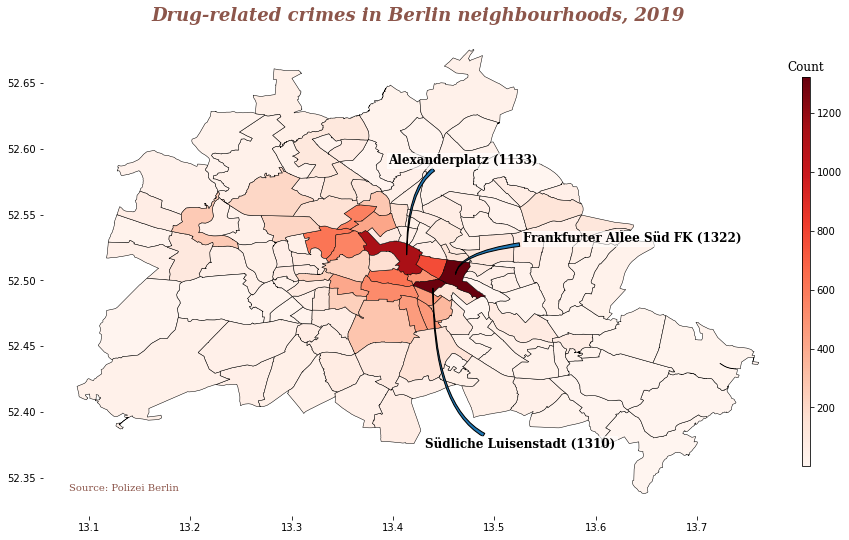

In [54]:
fig, ax = plt.subplots(figsize=(16,11))

gdf_by_neig.plot(ax=ax, column='Drugs', cmap='Reds',
                 edgecolor='black', lw=0.5)

#park.plot(ax=ax, color='tab:green', edgecolor='k', lw=0.1)
#river.plot(ax=ax, color='tab:blue', lw=1)

vmin = gdf_by_neig['Drugs'].min()
vmax = gdf_by_neig['Drugs'].max()
sm = plt.cm.ScalarMappable(cmap='Reds', norm=plt.Normalize(vmin=vmin, vmax=vmax))
cbar = fig.colorbar(sm, pad=0.01, shrink=0.65, aspect=50)
cbar.ax.set_title('Count', family='serif')

plt.annotate(f'{first_neig_name} ({first_neig_val})', xy=(0.55, 0.49), xytext=(0.64, 0.56), xycoords='axes fraction',
             arrowprops=dict(arrowstyle="wedge", connectionstyle="angle3,angleA=0,angleB=-90"),
             bbox=dict(color='white', alpha=0.6, pad=1),
             family='serif', size='large', style='normal', weight='bold')

plt.annotate(f'{second_neig_name} ({second_neig_val})', xy=(0.52, 0.47), xytext=(0.51, 0.14), xycoords='axes fraction',
             arrowprops=dict(arrowstyle="wedge", connectionstyle="angle3,angleA=0,angleB=-90"),
             bbox=dict(color='white', alpha=0.6, pad=1),
             family='serif', size='large', style='normal', weight='bold')

plt.annotate(f'{third_neig_name} ({third_neig_val})', xy=(0.485, 0.53), xytext=(0.46, 0.72), xycoords='axes fraction',
             arrowprops=dict(arrowstyle="wedge", connectionstyle="angle3,angleA=0,angleB=-90"),
             bbox=dict(color='white', alpha=0.6, pad=1),
             family='serif', size='large', style='normal', weight='bold')

ax.set(aspect=1.3, frame_on=False)

ax.text(13.08, 52.34, 'Source: Polizei Berlin',   #Vincenzo Ventriglia\n
        color='tab:brown', family='serif', style='normal', size=10)

plt.title('Drug-related crimes in Berlin neighbourhoods, 2019', color='tab:brown', family='serif', size=18, style='italic', weight='bold')

#plt.savefig(gdrive_path+"drug_neig_2019.png", dpi=200, bbox_inches='tight')
#files.download(gdrive_path+"drug_neig_2019.png");

Sometimes it is useful to include well-known locations on the maps. A fast (and *non-manual*) way to do it is to use the [geopy](https://github.com/geopy/geopy) library, which can fetch this type of data **automatically**

In [74]:
# Instantiate the object from the class - user_agent is the header to send with the requests to geocoder API
locator = Nominatim(user_agent='myGeocoder')

In [75]:
location = locator.geocode('Berliner Fernsehturm')
location.latitude, location.longitude

(52.520822749999994, 13.409420934251044)

We create a function wich accepts a (string out of the name of a) place, and returns its geographic **coordinates**

In [76]:
def get_coords(place):

  locator = Nominatim(user_agent='myGeocoder')
  location = locator.geocode(place)

  if location is None:
    None
  else:
    return location.latitude, location.longitude

In [87]:
places = ['Alexander Platz', 'Zoo Berlin', 'Berlin Tegel', 'Olympia Stadium Berlin', 'Frei Universität Berlin', 'Mauerpark', 'Kit Kat Club']

In [88]:
# Create a dictionary with place names as keys (k) and place coordinates as values
places_coord = {k: get_coords(k) for k in places}

In [107]:
places_coord
#list(places_coord.values())

{'Alexander Platz': (52.52197645, 13.413637435864272),
 'Berlin Tegel': (52.5881913, 13.2896968),
 'Frei Universität Berlin': (52.4550822, 13.296031557619791),
 'Kit Kat Club': (52.5112074, 13.4169157),
 'Mauerpark': (52.543990949999994, 13.401482055329105),
 'Olympia Stadium Berlin': (14.3449266, 121.0425257),
 'Zoo Berlin': (52.50844935, 13.339369555100077)}